## 1. Описание набора данных

### Источник данных
Данные были взяты из соревнования Kaggle ["Two Sigma Connect: Rental Listing Inquiries"](https://www.kaggle.com/competitions/two-sigma-connect-rental-listing-inquiries/data) и адаптированы под учебную задачу.

### О наборе данных
Набор данных представляет собой выдержку из более обширного датасета об объявлениях на аренду квартир в Нью-Йорке. Чтобы сфокусироваться на изучении основ, были отобраны ключевые признаки.

### Постановка задачи

**Тип задачи:** Регрессия

**Целевая переменная:** `price` (стоимость аренды)

**Цель:** Построить модель для прогнозирования стоимости аренды квартиры на основе её характеристик.

---


## 2. Импорт библиотек и загрузка данных

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [4]:
df_train = pd.read_json('../data/train.json')
df_test = pd.read_json('../data/test.json')

## 3. Предобработка данных

In [5]:
df_train.shape

(49352, 15)

In [6]:
df_train.columns

Index(['bathrooms', 'bedrooms', 'building_id', 'created', 'description',
       'display_address', 'features', 'latitude', 'listing_id', 'longitude',
       'manager_id', 'photos', 'price', 'street_address', 'interest_level'],
      dtype='object')

### 3.1 Быстрый анализ исходных данных

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49352 entries, 4 to 124009
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   bathrooms        49352 non-null  float64
 1   bedrooms         49352 non-null  int64  
 2   building_id      49352 non-null  object 
 3   created          49352 non-null  object 
 4   description      49352 non-null  object 
 5   display_address  49352 non-null  object 
 6   features         49352 non-null  object 
 7   latitude         49352 non-null  float64
 8   listing_id       49352 non-null  int64  
 9   longitude        49352 non-null  float64
 10  manager_id       49352 non-null  object 
 11  photos           49352 non-null  object 
 12  price            49352 non-null  int64  
 13  street_address   49352 non-null  object 
 14  interest_level   49352 non-null  object 
dtypes: float64(3), int64(3), object(9)
memory usage: 6.0+ MB


In [8]:
pd.set_option('display.float_format', '{:.2f}'.format)
# pd.reset_option('display.float_format')
df_train.describe()

,bathrooms,bedrooms,latitude,listing_id,longitude,price
count,49352.00,49352.00,49352.00,49352.00,49352.00,49352.00
mean,1.21,1.54,40.74,7024054.66,-73.96,3830.17
std,0.50,1.12,0.64,126274.61,1.18,22066.87
min,0.00,0.00,0.00,6811957.00,-118.27,43.00
25%,1.00,1.00,40.73,6915887.50,-73.99,2500.00
50%,1.00,1.00,40.75,7021070.50,-73.98,3150.00
75%,1.00,2.00,40.77,7128733.25,-73.95,4100.00
max,10.00,8.00,44.88,7753784.00,0.00,4490000.00


#### Общая информация
- **Всего записей:** 49,352
- **Пропущенные значения:** отсутствуют
- **Основная проблема:** наличие аномалий в данных

#### Географические аномалии
| Параметр | Значение | Локация | Проблема |
|----------|----------|---------|----------|
| **min latitude** | 0.0 | Экватор (Африка) | Не соответствует Нью-Йорку |
| **max latitude** | 44.88 | Северная Италия | Не соответствует Нью-Йорку |
| **min longitude** | -118.27 | Лос-Анджелес, США | Не соответствует Нью-Йорку |
| **max longitude** | 0.0 | Гринвич, Лондон | Не соответствует Нью-Йорку |


#### Аномалии в характеристиках квартир

##### Ванные комнаты
- **Максимальное значение:** 10 ванных комнат
- **Проблема:** Нереалистичное количество для квартиры

##### Спальные комнаты
- **Максимальное значение:** 8 спален
- **Проблема:** Нетипичное количество для квартиры

#### Ценовые аномалии
| Параметр | Значение | Проблема |
|--------------|----------|---------------------|
| **Минимальная цена** | $43 | Слишком маленькая цена для квартиры |
| **Максимальная цена** | $4,490,000 | Огромная цена для квартиры |

#### Стандартное отклонение цены
- **Стандартное отклонение цены:** $22,066.87 
- **Проблема:** Огромное значение

> Данные содержат значительное количество аномалий, требуется обработка перед дальнейшим анализом.

In [9]:
df_train.corr(numeric_only=True)

,bathrooms,bedrooms,latitude,listing_id,longitude,price
bathrooms,1.00,0.53,-0.01,0.00,0.01,0.07
bedrooms,0.53,1.00,-0.00,0.01,0.01,0.05
latitude,-0.01,-0.00,1.00,0.00,-0.97,-0.00
listing_id,0.00,0.01,0.00,1.00,-0.00,0.01
longitude,0.01,0.01,-0.97,-0.00,1.00,-0.00
price,0.07,0.05,-0.00,0.01,-0.00,1.00


#### Слабые связи с целевой переменной price:
- **`bathrooms` ↔ `price`**: 0.07
- **`bedrooms` ↔ `price`**: 0.05  
  Слабые корреляции - основные характеристики почти не влияют на цену

#### Сильно коррелированы географические признаки:
- **`latitude` ↔ `longitude`**: -0.97

In [10]:
df_train.isna().sum()

bathrooms          0
bedrooms           0
building_id        0
created            0
description        0
display_address    0
features           0
latitude           0
listing_id         0
longitude          0
manager_id         0
photos             0
price              0
street_address     0
interest_level     0
dtype: int64

### 3.2 Очистка обучающей выборки

#### Удаление квартир за пределами Нью-Йорка

In [11]:
initial_size = len(df_train)
print("Изначальное количество квартир: ", initial_size)

Изначальное количество квартир:  49352


In [12]:
def delete_non_ny(df, lat='latitude', lon='longitude'):
    lat_min = 40.50
    lat_max = 40.92
    lon_min = -74.05
    lon_max = -73.70

    filter_coordinates = (
        (df[lat] >= lat_min) & 
        (df[lat] <= lat_max) & 
        (df[lon] >= lon_min) & 
        (df[lon] <= lon_max))
    
    df_new = df[filter_coordinates].copy()
    return df_new


In [13]:
df_train_ny = delete_non_ny(df_train)

In [14]:
removed_apartments = initial_size - len(df_train_ny)
print(f"Количество удалённых квартир вне Нью-Йорка: {removed_apartments}")

Количество удалённых квартир вне Нью-Йорка: 68


#### Фильтр для цены, спален и ванных комтат

##### Актуальные рыночные данные (renthop.com): 

#####  Диапазон цен:
**$500 — $105,000**

##### Характеристики квартир:
- **Спальни:** до 7 
- **Ванные:** до 7

In [15]:
def filter_data(df):
    price_filter = (df['price'] >= 500) & (df['price'] <= 106000)
    bathrooms_filter = (df['bathrooms'] >= 0.5) & (df['bathrooms'] <= 7)
    bedrooms_filter = (df['bedrooms'] <= 7)

    final_filter = price_filter & bathrooms_filter & bedrooms_filter

    df_new = df[final_filter].copy()
    return df_new


In [16]:
df_train_clean = filter_data(df_train_ny)

In [17]:
removed_apartments = len(df_train_ny) - len(df_train_clean)
print(f"Количество удалённых квартир : {removed_apartments}")

Количество удалённых квартир : 323


#### Результаты очистки данных

In [18]:
print(f"Осталось квартир в Нью-Йорке: {len(df_train_clean)}")
print(f"Сколько % данных удалось сохранить: {len(df_train_clean)/len(df_train_ny)*100:.1f}%")

Осталось квартир в Нью-Йорке: 48961
Сколько % данных удалось сохранить: 99.3%


### 3.3 Очистка тестовой выборки

In [19]:
df_test.describe()

,bathrooms,bedrooms,latitude,listing_id,longitude,price
count,74659.00,74659.00,74659.00,74659.00,74659.00,74659.00
mean,1.21,1.54,40.74,7024000.59,-73.95,3749.03
std,0.65,1.11,0.81,126449.63,1.49,9713.09
min,0.00,0.00,0.00,6811958.00,-121.49,1.00
25%,1.00,1.00,40.73,6915516.50,-73.99,2495.00
50%,1.00,1.00,40.75,7021738.00,-73.98,3150.00
75%,1.00,2.00,40.77,7129165.50,-73.95,4100.00
max,112.00,7.00,42.87,7761779.00,0.00,1675000.00


In [20]:
df_test_ny = delete_non_ny(df_test)

In [21]:
df_test_clean = filter_data(df_test_ny)

In [22]:
removed_apartments_test = len(df_test) - len(df_test_clean)
print(f"Количество удалённых квартир в тестовом наборе: {removed_apartments_test}")
print(f"Сколько % данных удалось сохранить: {len(df_test_clean)/len(df_test)*100:.1f}%")

Количество удалённых квартир в тестовом наборе: 605
Сколько % данных удалось сохранить: 99.2%


In [23]:
df_test_clean.describe()

,bathrooms,bedrooms,latitude,listing_id,longitude,price
count,74054.00,74054.00,74054.00,74054.00,74054.00,74054.00
mean,1.22,1.55,40.75,7024028.60,-73.97,3663.38
std,0.49,1.11,0.04,126489.84,0.03,2339.05
min,1.00,0.00,40.56,6811958.00,-74.05,725.00
25%,1.00,1.00,40.73,6915524.75,-73.99,2495.00
50%,1.00,1.00,40.75,7021722.00,-73.98,3150.00
75%,1.00,2.00,40.77,7129114.75,-73.95,4100.00
max,6.50,7.00,40.92,7761779.00,-73.70,99999.00


In [24]:
df_test = df_test_clean[['bathrooms', 'bedrooms', 'price']]
df_test

,bathrooms,bedrooms,price
0,1.00,1,2950
1,1.00,2,2850
2,1.00,0,2295
3,1.00,2,2900
5,1.00,1,3254
...,...,...,...
124003,1.00,1,1700
124005,1.00,2,4195
124006,1.00,0,2400
124007,2.00,2,6895


### 3.4 Анализ очищенных данных

In [25]:
df_train_clean.describe()

,bathrooms,bedrooms,latitude,listing_id,longitude,price
count,48961.00,48961.00,48961.00,48961.00,48961.00,48961.00
mean,1.22,1.55,40.75,7024057.56,-73.97,3668.04
std,0.49,1.11,0.04,126306.53,0.03,2401.69
min,1.00,0.00,40.55,6811957.00,-74.05,700.00
25%,1.00,1.00,40.73,6915968.00,-73.99,2500.00
50%,1.00,1.00,40.75,7021013.00,-73.98,3150.00
75%,1.00,2.00,40.77,7128508.00,-73.95,4100.00
max,7.00,7.00,40.92,7753784.00,-73.70,100000.00


#### Общая информация
- **Всего записей:** 48,961 (удалена 391 запись с аномалиями)
- **Пропущенные значения:** отсутствуют
- **Качество данных:** значительно улучшено

#### Географические данные
| Параметр | Значение | Соответствие |
|----------|----------|--------------|
| **min latitude** | 40.55 |  Нью-Йорк |
| **max latitude** | 40.92 |  Нью-Йорк |
| **min longitude** | -74.05 |  Нью-Йорк |
| **max longitude** | -73.70 |  Нью-Йорк |

#### Характеристики квартир

##### Ванные комнаты
- **Диапазон:** 1.0 - 7.0 комнат
- **Соответствие:** реалистичные значения, соответствует рынку

##### Спальные комнаты
- **Диапазон:** 0 - 7 спален  
- **Соответствие:** соответствует рынку

#### Ценовые показатели
| Параметр | Значение | Статус |
|----------|----------|--------|
| **Минимальная цена** | $700 |  Соответствует рынку |
| **Максимальная цена** | $100,000 |  Соответствует рынку |
| **Медианная цена** | $3,150 |  Соответствует рынку |

#### Статистические улучшения
- **Стандартное отклонение цены:** $2,401.69
- **Улучшение:** уменьшилось в 9.2 раза (с $22,066)

In [26]:
df_train = df_train_clean[['bathrooms', 'bedrooms', 'interest_level', 'price', 'listing_id']]
df_train

,bathrooms,bedrooms,interest_level,price,listing_id
4,1.00,1,medium,2400,7170325
6,1.00,2,low,3800,7092344
9,1.00,2,medium,3495,7158677
10,1.50,3,medium,3000,7211212
15,1.00,0,low,2795,7225292
...,...,...,...,...,...
124000,1.00,3,low,2800,6824800
124002,1.00,2,medium,2395,6813268
124004,1.00,1,medium,1850,6927093
124008,1.00,2,medium,4195,6892816


## 4. Статистический анализ данных

In [27]:
print("Дубликаты: ", df_train.duplicated().sum())

Дубликаты:  0


In [28]:
df_train = df_train[['bathrooms', 'bedrooms', 'interest_level', 'price']]
df_train

,bathrooms,bedrooms,interest_level,price
4,1.00,1,medium,2400
6,1.00,2,low,3800
9,1.00,2,medium,3495
10,1.50,3,medium,3000
15,1.00,0,low,2795
...,...,...,...,...
124000,1.00,3,low,2800
124002,1.00,2,medium,2395
124004,1.00,1,medium,1850
124008,1.00,2,medium,4195


### 4.1 Анализ целевой переменной (price)

#### 1. Гистограмма (чтобы понять распределение цели)

In [29]:
def draw_hist(data, col_name, figsize=(15, 10), bins=None, title=None, xlabel=None, ylabel=None, range=None):
    plt.figure(figsize=figsize)

    data[col_name].hist(bins=bins, color='royalblue', edgecolor='white', linewidth=1.0, range=range)

    plt.title(title, fontsize=15, pad=20)
    plt.xlabel(xlabel, fontsize=12, labelpad=20)
    plt.ylabel(ylabel, fontsize=12, labelpad=20)

    plt.grid(alpha=0.3)
    plt.show()

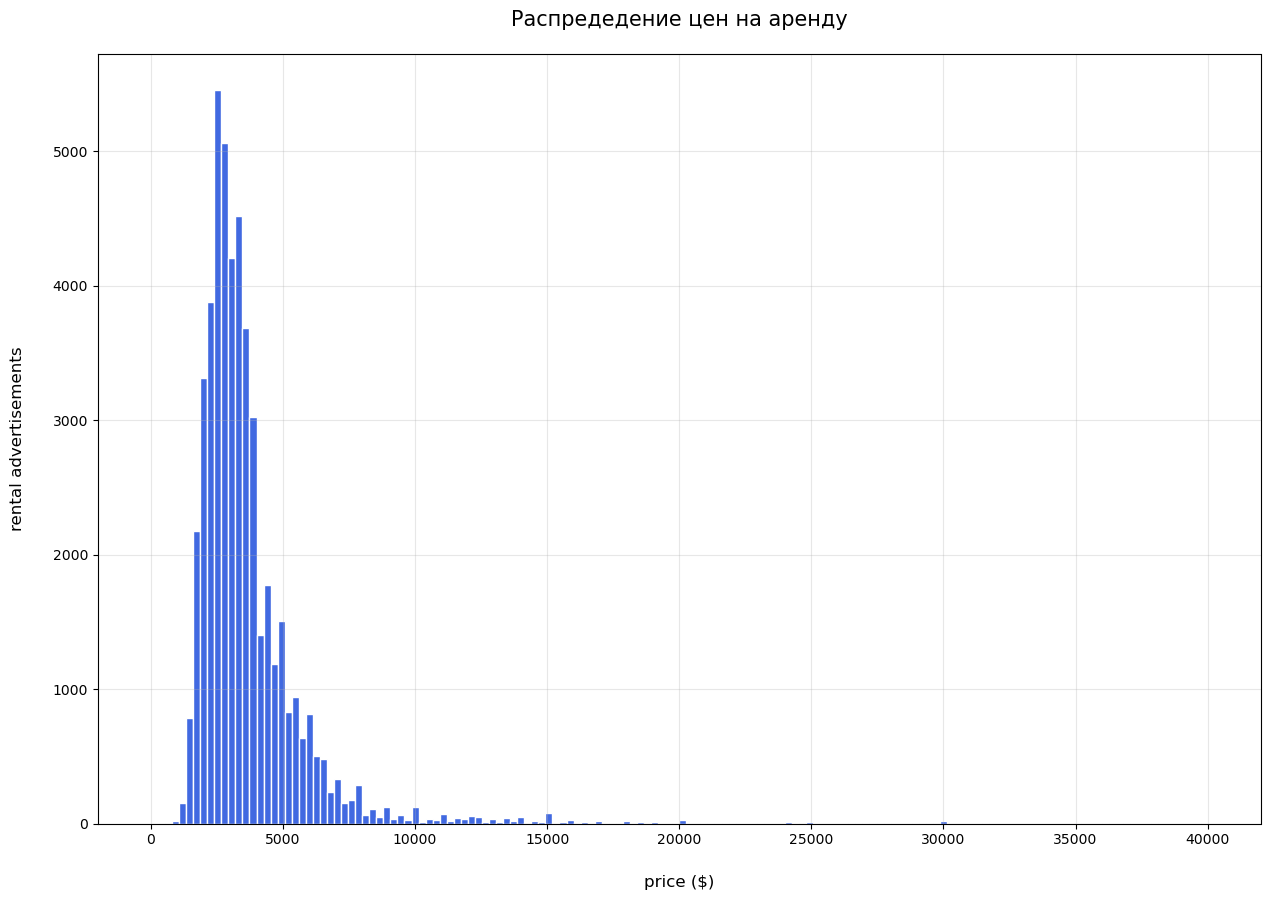

In [30]:
# для лучшей видимости: range=(0, 40000)
draw_hist(df_train,'price',bins=150, title='Распредедение цен на аренду', xlabel='price ($)', ylabel='rental advertisements', range=(0, 40000))

Видно, что большая часть квартир сосредоточена в левой части графика, наблюдается правостороннее (положительно скошенное) распределение. По гистограме можно сделать выводы, что типичная цена составляет 2,500-4,000$, бюджетный сегмент где-то до 2,500$, выше 10,000$ уже эксклюзивные предложения

#### 2. Boxplot (выбросы)

In [31]:
def draw_boxplot(data, col_name, vert=False, figsize=(15, 10), title=None, xlabel=None):
    plt.figure(figsize=figsize)

    boxplot = plt.boxplot(data[col_name], 
                      patch_artist=False, 
                      showmeans=True, 
                      vert=vert,
                      boxprops=dict(color='#008000', linewidth=3),
                      whiskerprops=dict(color='#e12826', linewidth=3),
                      capprops=dict(color='#e12826', linewidth=3),
                      medianprops=dict(color='#e12826', linewidth=2),
                      meanprops=dict(marker='>', markeredgecolor='#008000', markerfacecolor='#008000'),
                      flierprops=dict(marker='o', markersize=4, markerfacecolor='none'))
    
    q1 = data[col_name].quantile(0.25)
    q3 = data[col_name].quantile(0.75)
    iqr = q3 - q1
    upper_bound = q3 + 3 * iqr
    plt.xlim(0, upper_bound)

    plt.title(title, fontsize=15, pad=20)
    plt.xlabel(xlabel, fontsize=12, labelpad=20)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    print("СТАТИСТИКА:")
    print(f"Медиана: {data[col_name].median()}")
    print(f"Среднее: {data[col_name].mean()}")
    print(f"Q1: {q1}, Q3: {q3}")
    print(f"IQR: {iqr}")
    outliers = (data[col_name] > q3 + 1.5*iqr).sum()
    print(f"Выбросы (> Q3 + 1.5*IQR): {outliers}")
    print(f"Процент выбросов от общего количества: {outliers} из {len(data)} ({(outliers / len(data) * 100):.1f}%)")



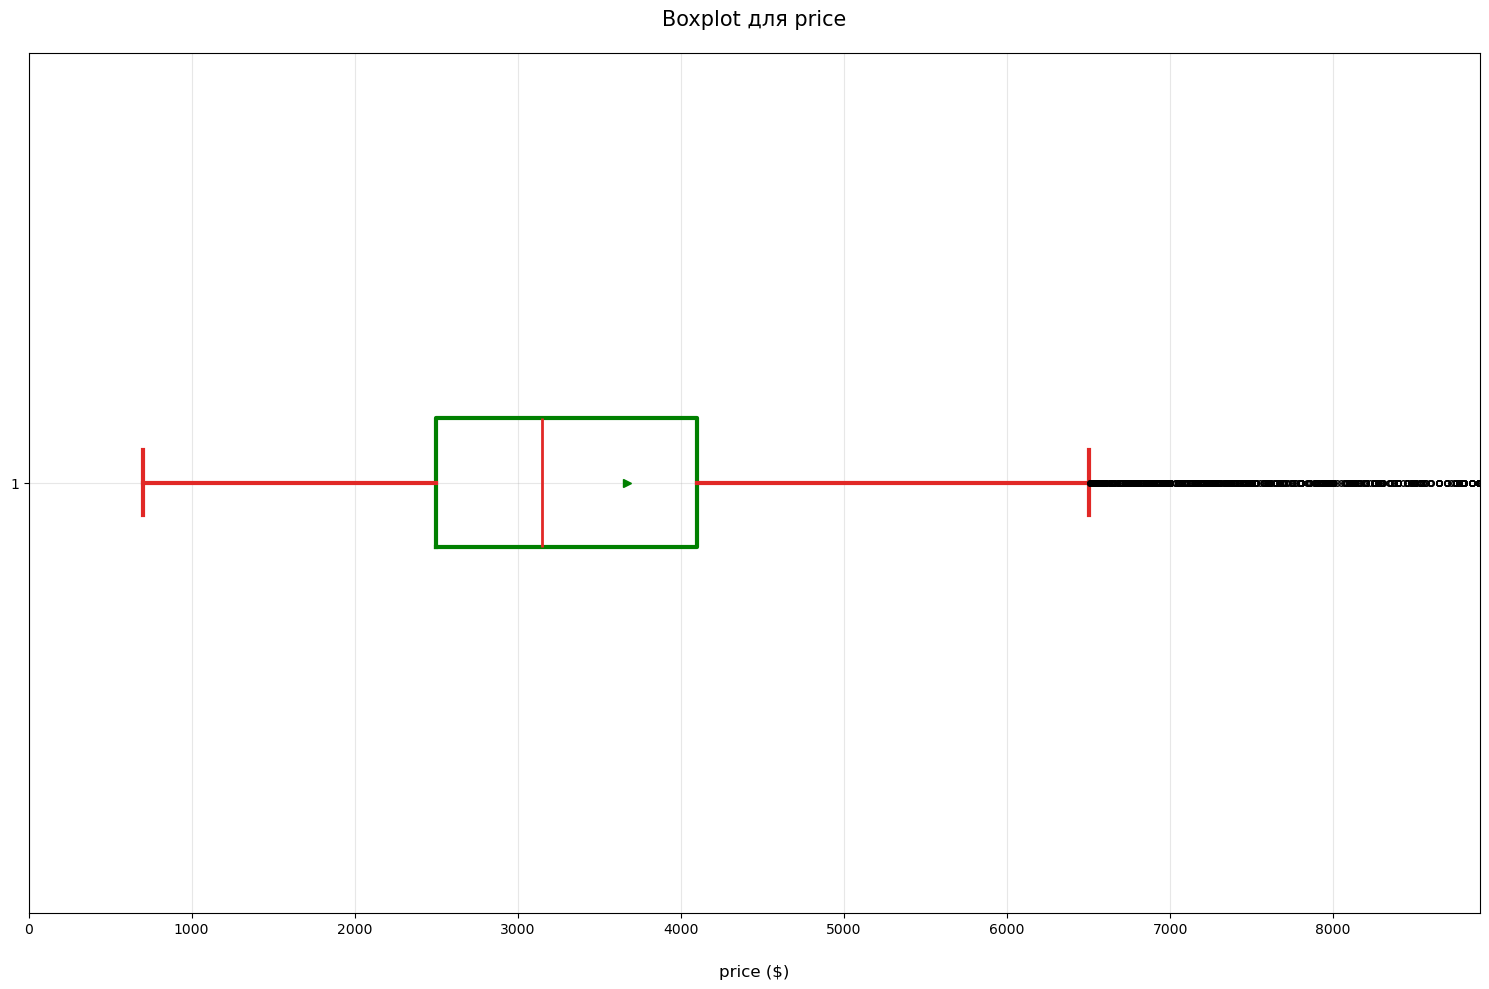

СТАТИСТИКА:
Медиана: 3150.0
Среднее: 3668.04307510059
Q1: 2500.0, Q3: 4100.0
IQR: 1600.0
Выбросы (> Q3 + 1.5*IQR): 2749
Процент выбросов от общего количества: 2749 из 48961 (5.6%)


In [32]:
draw_boxplot(df_train, 'price', vert=False, figsize=(15, 10), title='Boxplot для price', xlabel='price ($)')

| Показатель | Значение | Интерпретация |
|------------|----------|---------------|
| **Медиана** | $3,150 | Типичная стоимость аренды |
| **Среднее** | $3,668 | Смещено вправо из-за выбросов |
| **Q1** | $2,500 | 25% квартир дешевле $2,500 |
| **Q3** | $4,100 | 25% квартир дороже $4,100 |
| **IQR** | $1,600 | Средние 50% цен в этом диапазоне |

### 4.2 Анализ признаков (bathrooms, bedrooms)

#### 1. Закодируем значения в столбце interest_level, чтобы в превратить категории в числа для анализа (компьютер не понимает слова, но отлично работает с числами)

In [33]:
df_train['interest_level'].info()

<class 'pandas.core.series.Series'>
Index: 48961 entries, 4 to 124009
Series name: interest_level
Non-Null Count  Dtype 
--------------  ----- 
48961 non-null  object
dtypes: object(1)
memory usage: 765.0+ KB


In [34]:
df_train['interest_level'].value_counts()

interest_level
low       33917
medium    11212
high       3832
Name: count, dtype: int64

In [35]:
interest_level = {
    'low': 0,
    'medium': 1, 
    'high': 2
}

df_train['interest_level'] = df_train['interest_level'].map(interest_level)

C:\Users\Anna\AppData\Local\Temp\ipykernel_15064\1855917791.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['interest_level'] = df_train['interest_level'].map(interest_level)


In [36]:
df_train['interest_level']

4         1
6         0
9         1
10        1
15        0
         ..
124000    0
124002    1
124004    1
124008    1
124009    2
Name: interest_level, Length: 48961, dtype: int64

#### 2. Гистограммы для признаков «ванные комнаты» и «спальни»

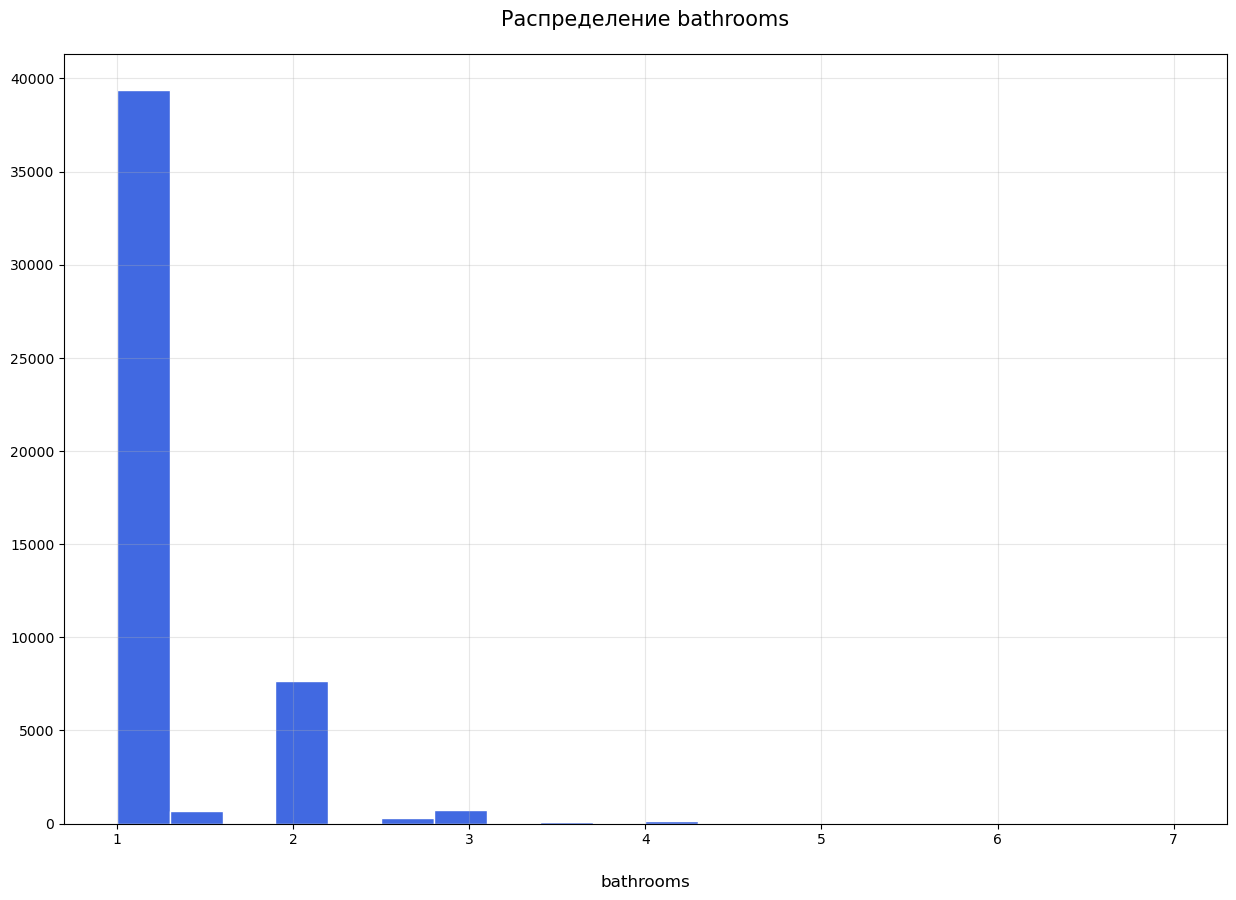

In [37]:
draw_hist(df_train,'bathrooms',bins=20, title='Распределение bathrooms', xlabel='bathrooms')

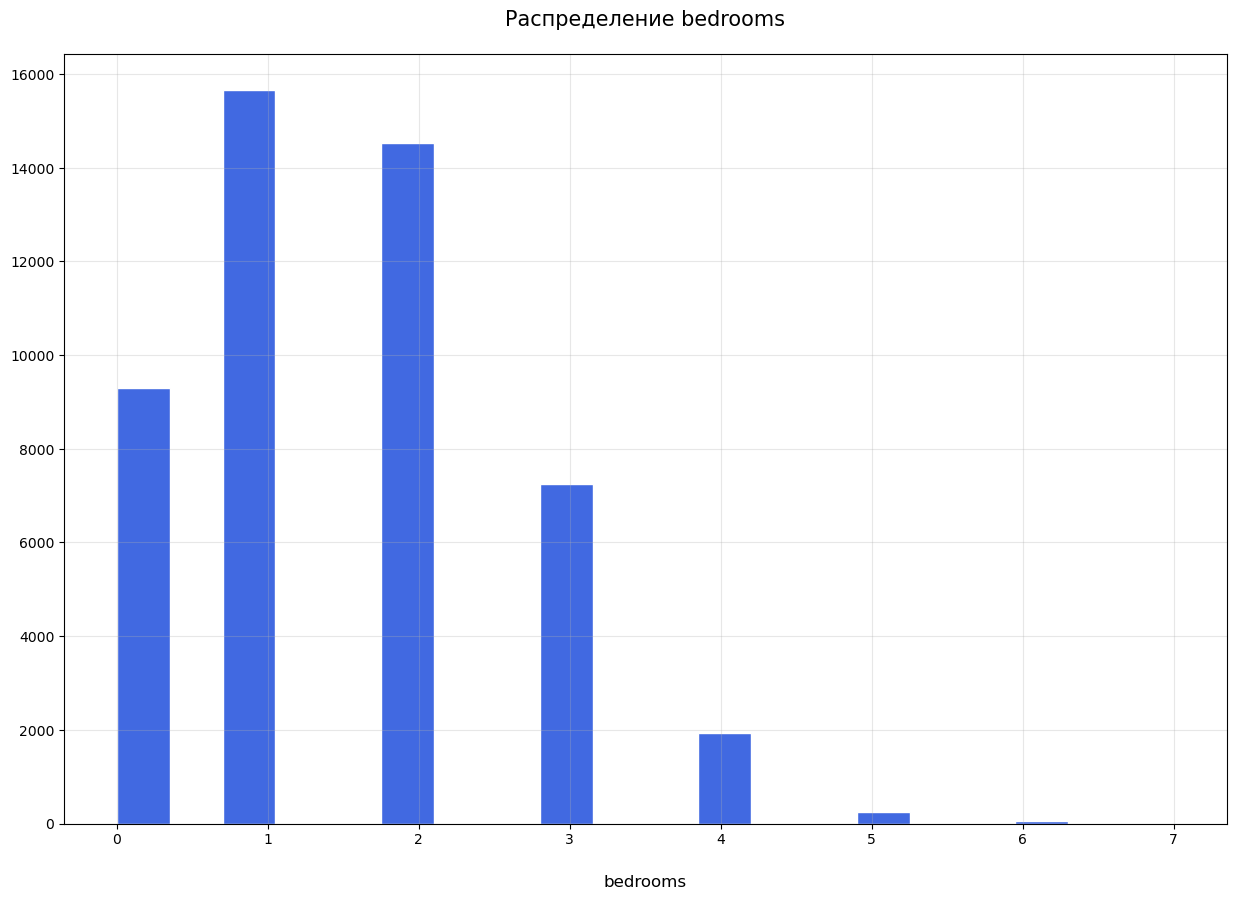

In [38]:
draw_hist(df_train,'bedrooms',bins=20, title='Распределение bedrooms', xlabel='bedrooms')

#### **Критических выбросов НЕТ**

**Почему:**

- **Все значения** соответствуют реальному рынку недвижимости
- **Редкие случаи** (5-7 комнат) - это премиальный сегмент, а не ошибки  
- **Распределения** логичны и отражают структуру рынка

### 4.3 Анализ взаимосвязей

#### 1. Корреляционная матрица(чтобы понять взаимосвязь между признаками и целевым объектом) и тепловая карта для корреляционной матрицы

In [39]:
corr_matrix = df_train.corr()
print(corr_matrix)

                bathrooms  bedrooms  interest_level  price
bathrooms            1.00      0.54           -0.09   0.69
bedrooms             0.54      1.00            0.03   0.47
interest_level      -0.09      0.03            1.00  -0.18
price                0.69      0.47           -0.18   1.00


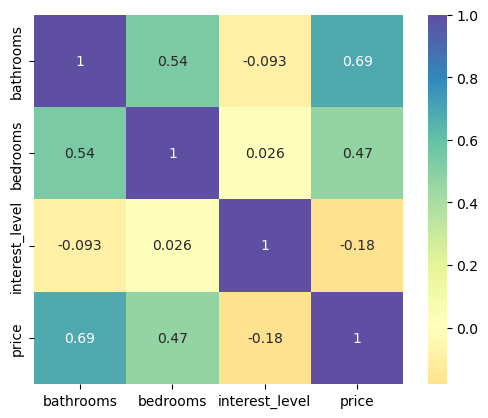

In [40]:
sns.heatmap(corr_matrix, annot=True, cmap='Spectral', center=0, square=True)
plt.show()

#### Выводы:
- **Ванные комнаты → цена**: 0.69
  - Самый сильный фактор влияния на стоимость аренды, чем больше ванных комнат, тем выше цена
- **Спальни → цена**: 0.47
  - Второй по значимости фактор влияния на стоимость аренды
- **Ванные ↔ спальни**: 0.54
  - Логичная взаимосвязь: чем больше спален, тем больше ванных
- **Уровень интереса → цена**: -0.18
  - Чем дороже квартира, тем ниже уровень интереса и наоборот

#### 2. Диаграмма рассеяния для визуализации корреляции между признаками и целевым значением

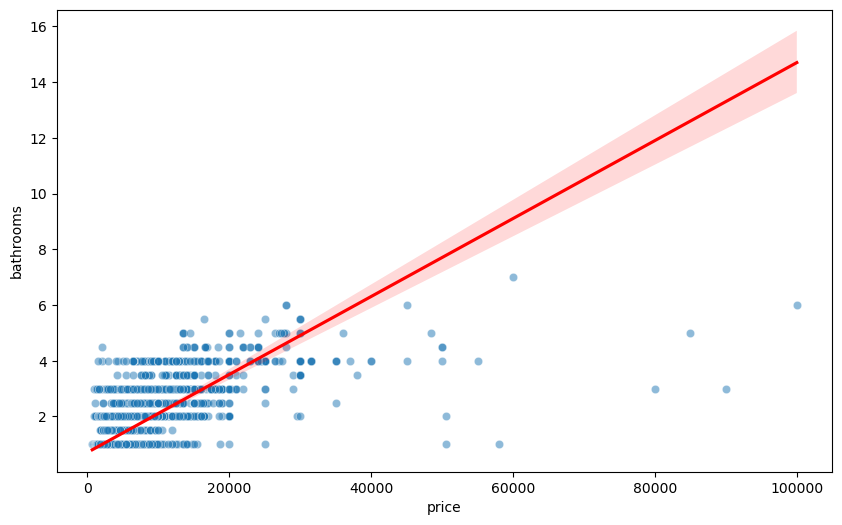

In [41]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=df_train, x='price', y='bathrooms', alpha=0.5)
sns.regplot(data=df_train, x='price', y='bathrooms', scatter=False, line_kws={"color": "red"}) 
plt.show()

In [42]:
bathrooms_corr = df_train['price'].corr(df_train['bathrooms'])
print(bathrooms_corr)

0.6854975479336579


#####  Коэффициент детерминации для bathrooms
**R² = (correlation)²** - это коэффициент детерминации, который показывает, какую долю дисперсии целевой переменной объясняет признак. Чем выше **R²**, тем меньше разброс, тем лучше признак объясняет данные

In [43]:
bathrooms_r2 = bathrooms_corr ** 2
print(f"bathrooms: R² = {(bathrooms_r2*100):.1f}%")

bathrooms: R² = 47.0%


#### Анализ взаимосвязи цены и количества ванных комнат:

- Направление: положительное, каждая дополнительная ванная комната дает существенную прибавку к стоимости аренды квартиры
- Форма: линейная
- Сила связи: сильная линейная связь
- Коэффициент корреляции Пирсона : 0.69 - сильная положительная корреляция, наиболее значимая среди всех признаков
- Разброс : умеренный разброс. R² = 47%, т.е. 47% изменчивости цены объясняется ванными комнатами, остальные 53% объясняется другими факторами
- Линия регрессии: круто восходящая, точно следует за основным скоплением точек


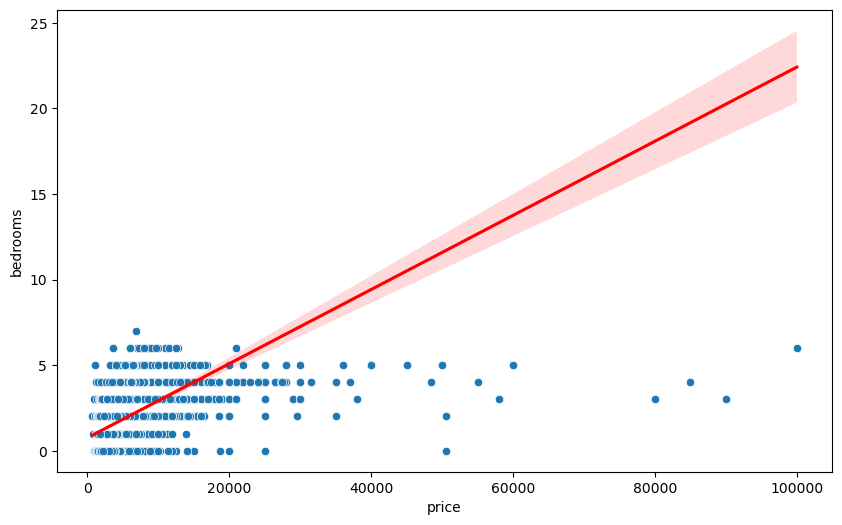

In [44]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=df_train, x='price', y='bedrooms')
sns.regplot(data=df_train, x='price', y='bedrooms', scatter=False, line_kws={"color": "red"}) 
plt.show()

In [45]:
bedrooms_corr = df_train['price'].corr(df_train['bedrooms'])
print(bedrooms_corr)

0.4675208423323855


#####  Коэффициент детерминации для bedrooms

In [46]:
bedrooms_r2 = bedrooms_corr ** 2
print(f"bedrooms: R² = {(bedrooms_r2*100):.1f}%")

bedrooms: R² = 21.9%


#### Анализ взаимосвязи цены и количества спальных комнат:

- Направление: положительное, каждая дополнительная спальня в среднем добавляет к стоимости аренды
- Форма: линейная
- Сила связи: умеренная связь
- Коэффициент корреляции Пирсона : 0.47, что свидетельствует умеренной силе связи
- Разброс : сильный. R² = 21.9%, т.е. только 21.9% изменчивости цены объясняется спальнями, остальные 78.1% - другими факторами
- Линия регрессии: восходящая прямая с положительным наклоном

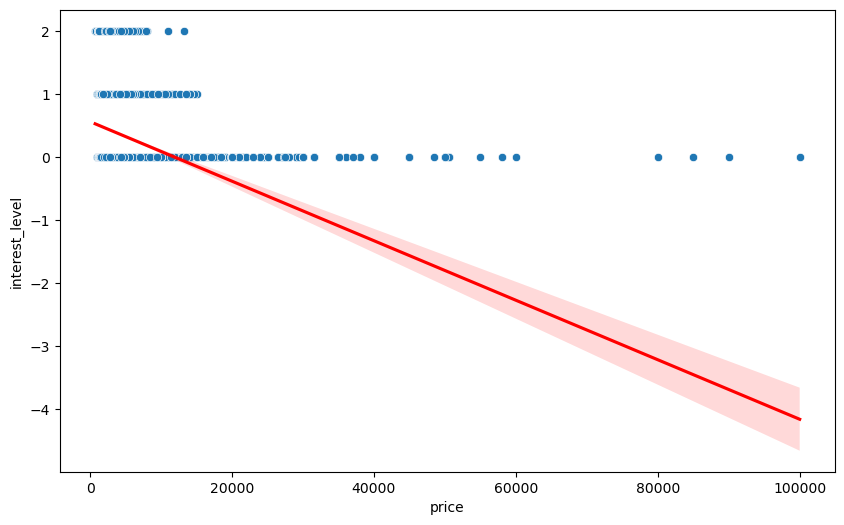

In [47]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=df_train, x='price', y='interest_level')
sns.regplot(data=df_train, x='price', y='interest_level', scatter=False, line_kws={"color": "red"}) 
plt.show()

In [48]:
interest_level_cor = df_train['price'].corr(df_train['interest_level'])
print(interest_level_cor)

-0.18049488896989818


#####  Коэффициент детерминации для interest_level

In [49]:
interest_level_r2 = interest_level_cor ** 2
print(f"interest_level: R² = {(interest_level_r2*100):.1f}%")

interest_level: R² = 3.3%


#### Анализ взаимосвязи цены и уровня интереса:

- Направление: слабо отрицательное, обычно с ростом цены уровень интереса к объекту в среднем снижается 
- Форма: нелинейная форма, наблюдается "горб" максимального интереса в среднем ценовом диапазоне
- Сила связи: слабая сила связи, уровень интереса слабо влияет на образование цены
- Коэффициент корреляции Пирсона : -0.18, что подтверждает слабую силу связи
- Разброс : очень сильный разброс. R² = 3.3%, т.е. только 3.3% изменчивости цены объясняется уровнем интереса, остальные 96.7% - другими факторами
- Линия регрессии: пологий нисходящий тренд, слабо следующий за основным распределением точек

## 5. Feature Engineering

### 5.1 Создание полиномиальных признаков

##### Нужно добавить три новых признака, возведённых в квадрат: «bathrooms_squared», «bedrooms_squared», «interest_level_squared»

In [50]:
df_squared = df_train.copy()

In [51]:
df_squared['bathrooms_squared'] = df_squared['bathrooms'] ** 2
df_squared['bedrooms_squared'] = df_squared['bedrooms'] ** 2
df_squared['interest_level_squared'] = df_squared['interest_level'] ** 2

### 5.2 Анализ эффективности новых признаков

In [52]:
squared_corr_matrix = df_squared.corr()
# print(squared_corr_matrix)

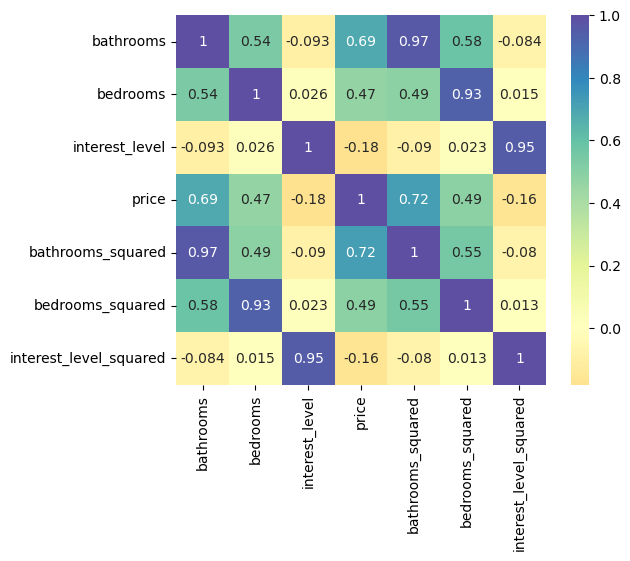

In [53]:
sns.heatmap(squared_corr_matrix, annot=True, cmap='Spectral', center=0, square=True)
plt.show()

#### Коррелируют ли новые признаки с целевой матрицей сильнее, чем исходные?
##### Новые признаки не коррелируют с целевой переменной ЗНАЧИТЕЛЬНО сильнее, чем исходные, поскольку исходные близки к линейным 

In [54]:
df_test.isna().sum()

bathrooms    0
bedrooms     0
price        0
dtype: int64

In [55]:
df_squared = df_squared[['bathrooms', 'bedrooms','price']]
df_squared

,bathrooms,bedrooms,price
4,1.00,1,2400
6,1.00,2,3800
9,1.00,2,3495
10,1.50,3,3000
15,1.00,0,2795
...,...,...,...
124000,1.00,3,2800
124002,1.00,2,2395
124004,1.00,1,1850
124008,1.00,2,4195


In [56]:
X = df_squared[['bathrooms', 'bedrooms']]
y = df_squared[['price']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
poly_conv = PolynomialFeatures(degree=2)

X_train_poly = poly_conv.fit_transform(X_train)
X_test_poly = poly_conv.transform(X_test)

In [57]:
print(f"Созданные полиномиальные признаки: {poly_conv.n_output_features_}")
print(f"Обучающие данные до преобразования: {X_train.shape}")
print(f"Обучающие данные после преобразования: {X_train_poly.shape}")
print(f"Тестовые данные до преобразования: {X_test.shape}")
print(f"Тестовые данные после преобразования: {X_test_poly.shape}")

Созданные полиномиальные признаки: 6
Обучающие данные до преобразования: (39168, 2)
Обучающие данные после преобразования: (39168, 6)
Тестовые данные до преобразования: (9793, 2)
Тестовые данные после преобразования: (9793, 6)


In [58]:
col_names = poly_conv.get_feature_names_out(['bathrooms', 'bedrooms'])
X_test_poly_df = pd.DataFrame(X_test_poly, columns=col_names)
X_test_poly_df

,1,bathrooms,bedrooms,bathrooms^2,bathrooms bedrooms,bedrooms^2
0,1.00,1.00,2.00,1.00,2.00,4.00
1,1.00,1.00,1.00,1.00,1.00,1.00
2,1.00,1.00,3.00,1.00,3.00,9.00
3,1.00,1.00,0.00,1.00,0.00,0.00
4,1.00,1.00,2.00,1.00,2.00,4.00
...,...,...,...,...,...,...
9788,1.00,1.00,1.00,1.00,1.00,1.00
9789,1.00,1.00,0.00,1.00,0.00,0.00
9790,1.00,1.00,2.00,1.00,2.00,4.00
9791,1.00,1.00,0.00,1.00,0.00,0.00


In [59]:
print("Статистика полиномиальных признаков:")
print(X_test_poly_df.describe())

Статистика полиномиальных признаков:
            1  bathrooms  bedrooms  bathrooms^2  bathrooms bedrooms  \
count 9793.00    9793.00   9793.00      9793.00             9793.00   
mean     1.00       1.22      1.56         1.74                2.20   
std      0.00       0.49      1.12         1.91                2.46   
min      1.00       1.00      0.00         1.00                0.00   
25%      1.00       1.00      1.00         1.00                1.00   
50%      1.00       1.00      1.00         1.00                1.50   
75%      1.00       1.00      2.00         1.00                3.00   
max      1.00       7.00      6.00        49.00               35.00   

       bedrooms^2  
count     9793.00  
mean         3.66  
std          4.31  
min          0.00  
25%          1.00  
50%          1.00  
75%          4.00  
max         36.00  


## 6. Обучение и оценка моделей

In [60]:
X_train = df_train[['bathrooms', 'bedrooms']]
y_train = df_train['price']

X_test = df_test[['bathrooms', 'bedrooms']]
y_test = df_test['price']

print(f"Обучающая выборка: {X_train.shape}")
print(f"Тестовая выборка: {X_test.shape}")

Обучающая выборка: (48961, 2)
Тестовая выборка: (74054, 2)


In [61]:
result_MAE = pd.DataFrame(columns=['model', 'train', 'test'])
result_RMSE = pd.DataFrame(columns=['model', 'train', 'test'])

### 6.1 Линейная регрессия

In [62]:
linreg = LinearRegression()

In [63]:
linreg.fit(X_train, y_train)

LinearRegression()

In [64]:
y_train_pred = linreg.predict(X_train)
y_test_pred = linreg.predict(X_test)

#### Сохраним результаты

In [65]:
df_train_lr = X_train.copy()
df_test_pred_lr = X_test.copy()

In [66]:
df_train_lr['price_real'] = y_train
df_test_pred_lr['price_real'] = y_test

In [67]:
df_train_lr['price_predict'] = y_train_pred
df_test_pred_lr['price_predict'] = y_test_pred

In [68]:
# df_test_pred

#### Вычисление метрик качества

MAE (Mean Absolute Error) - средняя абсолютная ошибка

*MAE* — это среднее значение абсолютных разниц между предсказанными и истинными значениями. Проще говоря, она показывает, "на сколько единиц в среднем ошибаются наши прогнозы"

$$
\text{MAE} = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|
$$

MSE (Mean Squared Error) - Средняя квадратичная ошибка

*MSE* — это среднее значение квадратов разниц между предсказанными и истинными значениями.

$$
\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
$$

RMSE (Root Mean Squared Error) - Cреднеквадратичная ошибка

*RMSE* — это просто квадратный корень из MSE.

$$
\text{RMSE} = \sqrt{\text{MSE}} = \sqrt{ \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 }
$$

In [69]:
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

In [70]:
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

In [71]:
result_MAE.loc[0] = ['linear_regression', train_mae, test_mae]
result_RMSE.loc[0] = ['linear_regression', train_rmse, test_rmse]

### 6.2 Дерево решений

In [72]:
dtree = DecisionTreeRegressor(random_state=21)

In [73]:
dtree.fit(X_train, y_train)

y_train_pred_dt = dtree.predict(X_train)
y_test_pred_dt = dtree.predict(X_test)

In [74]:
df_train_dt = X_train.copy()
df_test_result_dt = X_test.copy()

In [75]:
df_train_dt['price_real'] = y_train
df_test_result_dt['price_real'] = y_test

In [76]:
df_train_dt['price_predict'] = y_train_pred_dt
df_test_result_dt['price_predict'] = y_test_pred_dt

In [77]:
df_train_dt

,bathrooms,bedrooms,price_real,price_predict
4,1.00,1,2400,3017.22
6,1.00,2,3800,3201.28
9,1.00,2,3495,3201.28
10,1.50,3,3000,4100.92
15,1.00,0,2795,2461.41
...,...,...,...,...
124000,1.00,3,2800,3915.50
124002,1.00,2,2395,3201.28
124004,1.00,1,1850,3017.22
124008,1.00,2,4195,3201.28


In [78]:
train_mae = mean_absolute_error(y_train, y_train_pred_dt)
test_mae = mean_absolute_error(y_test, y_test_pred_dt)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred_dt))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_dt))

In [79]:
result_MAE.loc[1] = ['decision_tree', train_mae, test_mae]
result_RMSE.loc[1] = ['decision_tree', train_rmse, test_rmse]

In [80]:
# result_RMSE

### 6.3 Наивные модели

Среднее значение и медиана «цены» по обучающим и тестовым данным

In [81]:
mean = y_train.mean()
median = y_train.median()

In [82]:
y_train_pred_mean = np.full_like(y_train, mean)
y_train_pred_median = np.full_like(y_train, median)

y_test_pred_mean = np.full_like(y_test, mean)
y_test_pred_median = np.full_like(y_test, median)

In [83]:
train_mae_mean = mean_absolute_error(y_train, y_train_pred_mean)
test_mae_mean = mean_absolute_error(y_test, y_test_pred_mean)

train_mae_median = mean_absolute_error(y_train, y_train_pred_median)
test_mae_median = mean_absolute_error(y_test, y_test_pred_median)

In [84]:
train_rmse_mean = np.sqrt(mean_squared_error(y_train, y_train_pred_mean))
test_rmse_mean = np.sqrt(mean_squared_error(y_test, y_test_pred_mean))

train_rmse_median = np.sqrt(mean_squared_error(y_train, y_train_pred_median))
test_rmse_median = np.sqrt(mean_squared_error(y_test, y_test_pred_median))

In [85]:
result_MAE.loc[2] = ['naive_mean', train_mae_mean, test_mae_mean]
result_RMSE.loc[2] = ['naive_mean', train_rmse_mean, test_rmse_mean]

In [86]:
result_MAE.loc[3] = ['naive_median', train_mae_median, test_mae_median]
result_RMSE.loc[3] = ['naive_median', train_rmse_median, test_rmse_median]

### 6.4 Сравнительная таблица результатов

In [87]:
result_MAE

,model,train,test
0,linear_regression,911.60,913.04
1,decision_tree,840.39,854.35
2,naive_mean,1324.52,1322.47
3,naive_median,1235.60,1233.83


In [88]:
result_RMSE

,model,train,test
0,linear_regression,1725.35,1661.23
1,decision_tree,1546.84,1716.72
2,naive_mean,2401.66,2339.04
3,naive_median,2456.90,2394.71


## 7. Выбор лучшей модели и выводы

Лучшей моделью оказалось Decision Tree (дерево решений)

В таблице result_MAE у данной модели лучший результат на тестовых данных  - 854.35. Это значит, что в среднем предсказания Decision Tree отличаются от реальной цены на 854.35$. Это меньше, чем у любой другой модели

В таблице result_RMSE модель тоже показала хороший результат - 1716.72, что означает, что у нее не только в среднем ошибки меньше, но и у неё меньше именно крупных, неприемлемых ошибок.

### Итоговый вывод: 
Decision Tree — лучшая модель для поставленной задачи, так как она обеспечивает наименьшую среднюю ошибку (MAE) на тестовой выборке, что является основной целью построения модели предсказания цены. При этом разница между ошибками на обучающей и тестовой выборках минимальна (854.35 vs 840.39), что свидетельствует об хорошей обобщающей способности модели без значительного переобучения.